# Hands-on Day 4

## You'll learn

### ML methods

- Deep NN with BigDL

In [1]:
# initial imports
%reload_ext custom_magics
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

np.random.seed(1337)  # for reproducibility

from custom_functions import *

In [2]:
num_workers = 7  # Do not use more than 7!
spark = %sc_bigDL $num_workers

from pyspark.sql import SparkSession

spark_session = SparkSession(spark)

# check if spark is there
spark
# spark._conf.getAll()

Exception in thread Thread-3:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/threading.py", line 973, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 126, in run
    self.onrecv(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 143, in onrecv
    sendToFrontEnd({
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 223, in sendToFrontEnd
    monitor.send(msg)
  File "/opt/conda/lib/python3.9/site-packages/sparkmonitor/kernelextension.py", line 57, in send
    self.comm.send(msg)
AttributeError: 'ScalaMonitor' object has no attribute 'comm'


<SparkContext master=k8s://https://192.168.2.39:6443 appName=jupyter-marchisi01>

In [3]:
# init bigDL context

from bigdl.dllib.nncontext import *

sc = init_nncontext()

/opt/conda/lib/python3.9/site-packages/bigdl/dllib/utils/engine.py:45: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark, and pyspark is found in: /opt/conda/lib/python3.9/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


## Read in input data

In [4]:
inputFile = "file:///home/jovyan/Higgs100k.parquet"
# inputFile = 'file:///home/jovyan/Higgs1M.parquet'
# inputFile = 'file:///home/jovyan/Higgs10M.parquet'

%time df = spark_session.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print("There are " + str(total_events) + " events")

CPU times: user 3.79 ms, sys: 750 µs, total: 4.54 ms
Wall time: 3.89 s
There are 99999 events


In [5]:
# split the dataset for training and test
train, test = df.randomSplit([0.8, 0.2])

print("Events for training {}".format(train.count()))
print("Events for validation {}".format(test.count()))


Events for training 80108
Events for validation 19891


In [6]:
# create input feature vector
feature = train.columns
feature.remove("label")

from pyspark.ml.feature import VectorAssembler

# VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol="features")


In [7]:
train = assembler.transform(train)
test = assembler.transform(test)

In [8]:
# In how many partitions is the dataframe distributed?
print("Number of partitions: {}".format(train.rdd.getNumPartitions()))
print("Partitioner: {}".format(train.rdd.partitioner))

Number of partitions: 6
Partitioner: None


## Exercise: create the model

- documentation: https://keras.io/getting-started/sequential-model-guide/
- Build (compile) a Keras Sequential model (call it *model*)
  - 1 hidden layer  with 100 neurons, activation ReLU (put in the correct input_shape!)
  - 1 ouput layer with activation sigmoid
  - use Adam optimiser
  - use binary_crossentropy loss
  - use accuracy metrics 

In [11]:
# Create keras-like model:
# Only need to change package name from tensorflow.keras to bigdl.dllib.keras
# no callbacks in bigDL

from bigdl.dllib.keras.layers import *
from bigdl.dllib.keras.models import Sequential
from bigdl.dllib.utils.common import JTensor

from bigdl.dllib.keras.optimizers import Adam
from bigdl.dllib.keras.layers.core import Dense, Activation, Dropout

In [12]:
# create the model
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=(28,)))
model.add(Dense(1, activation="sigmoid"))
opt = Adam()

creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasAdam
creating: createDefault


In [13]:
# Compile model
model.compile(
    loss="binary_crossentropy",
    optimizer=opt,
    metrics=["accuracy"],
)

creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy


In [14]:
# Set of hyperparameters
numEpochs = 10

# The batch used by BigDL must be a multiple of numExecutors * executorCores because data will be equally distributed inside each executor
# scale up or down according to size of input dataset
workerBatch = 140
numExecutors = int(sc._conf.get("spark.executor.instances"))
executorCores = int(sc._conf.get("spark.executor.cores"))

BigDLbatch = workerBatch * numExecutors * executorCores

print(str(BigDLbatch))

980


In [15]:
# Create SparkML compatible estimator for deep learning training
from bigdl.dllib.optim.optimizer import (
    EveryEpoch,
    Loss,
    TrainSummary,
    ValidationSummary,
)
from bigdl.dllib.nnframes import *
from bigdl.dllib.keras.objectives import BinaryCrossEntropy

estimator = (
    NNEstimator(model, BinaryCrossEntropy())
    .setOptimMethod(Adam())
    .setBatchSize(BigDLbatch)
    .setMaxEpoch(numEpochs)
    .setFeaturesCol("features")
    .setLabelCol("label")
    .setValidation(
        trigger=EveryEpoch(),
        val_df=test,
        val_method=[Loss(BinaryCrossEntropy())],
        batch_size=BigDLbatch,
    )
)

creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createEveryEpoch
creating: createZooKerasBinaryCrossEntropy
creating: createLoss


## Create directory for logs

In [16]:
appName = "Classifier"
logDir = "/home/jovyan/bigDL"

# Check if there is already an application with the same name and remove it, otherwise logs will be appended to that app
import os

try:
    os.system("rm -rf " + logDir + "/" + appName)
except:
    pass

print("Saving logs to {}".format(logDir + "/" + appName))

trainSummary = TrainSummary(log_dir=logDir, app_name=appName)
estimator.setTrainSummary(trainSummary)

valSummary = ValidationSummary(log_dir=logDir, app_name=appName)
estimator.setValidationSummary(valSummary)

Saving logs to /home/jovyan/bigDL/Classifier
creating: createTrainSummary
creating: createValidationSummary


NNEstimator_e61fe621c1e6

## Train model

In [15]:
# keep spark UI close!!!
# %time trained_model = estimator.fit(train)
import time

start_train = time.time()
trained_model = estimator.fit(train)
train_time = time.time() - start_train
print(f"Training time: {train_time} seconds")

creating: createToTuple
creating: createChainedPreprocessing
Training time: 265.4752185344696 seconds


In [16]:
# Predict with trained NNModel using pipeline transform API
predDF = trained_model.transform(test)
# predDF.printSchema()

y_pred = np.asarray(predDF.select("prediction").collect())
y_true = np.asarray(test.select("label").collect())

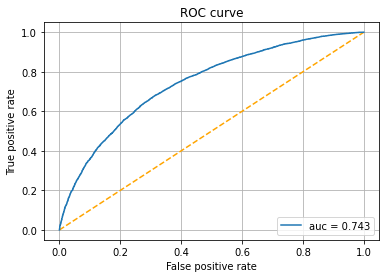

In [17]:
drawROC2(y_true[:, 0], y_pred[:, 0])

In [18]:
# create dataframe in same format as MLlib
from pyspark.sql import functions as f

# rename prediction to probability (predictions are binary, 0-1)
newDF = predDF.withColumn("probability", f.col("prediction"))
# overwrite prediction with binary values
result = newDF.withColumn(
    "prediction", f.when(f.col("probability")[0] > 0.5, 1.0).otherwise(0.0)
)
result.select(["probability", "prediction", "label"]).show()

+-------------+----------+-----+
|  probability|prediction|label|
+-------------+----------+-----+
|  [0.2616308]|       0.0|  0.0|
| [0.15691873]|       0.0|  0.0|
|  [0.0418349]|       0.0|  0.0|
| [0.37498137]|       0.0|  0.0|
|[0.057549205]|       0.0|  0.0|
|  [0.4456313]|       0.0|  0.0|
| [0.49073476]|       0.0|  0.0|
| [0.28313214]|       0.0|  0.0|
| [0.50046587]|       1.0|  0.0|
| [0.40606463]|       0.0|  0.0|
|   [0.545808]|       1.0|  0.0|
|  [0.6775876]|       1.0|  0.0|
|  [0.7107462]|       1.0|  0.0|
| [0.36088207]|       0.0|  0.0|
|  [0.5564582]|       1.0|  0.0|
|  [0.4796239]|       0.0|  0.0|
|  [0.2781475]|       0.0|  0.0|
| [0.59428364]|       1.0|  0.0|
| [0.26850486]|       0.0|  0.0|
| [0.19855334]|       0.0|  0.0|
+-------------+----------+-----+
only showing top 20 rows



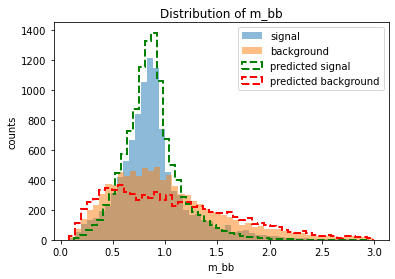

In [19]:
# plot signal vs background with prediction
plotSignalvsBgWithPrediction(test, result, "m_bb")

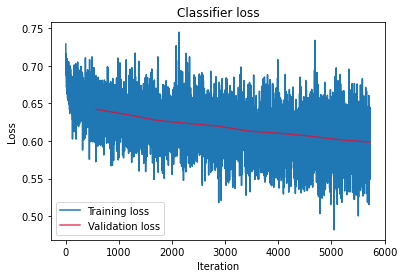

In [20]:
# Plot loss
plotLoss(trainSummary, valSummary)

In [31]:
!kubectl get pods

NAME                                         READY   STATUS    RESTARTS   AGE
jupyter-marchisi01-01a9249b46ed7a54-exec-1   1/1     Running   0          47m
jupyter-marchisi01-01a9249b46ed7a54-exec-2   1/1     Running   0          47m
jupyter-marchisi01-01a9249b46ed7a54-exec-3   1/1     Running   0          47m
jupyter-marchisi01-01a9249b46ed7a54-exec-4   1/1     Running   0          47m
jupyter-marchisi01-01a9249b46ed7a54-exec-5   1/1     Running   0          47m
jupyter-marchisi01-01a9249b46ed7a54-exec-6   1/1     Running   0          47m
jupyter-marchisi01-01a9249b46ed7a54-exec-7   1/1     Running   0          47m
jupyter-marchisi01-e991539b46d449c2-exec-1   1/1     Running   0          74m


In [32]:
# Once done, stop spark
spark.stop()

## Exercise

- play with the batch size, how does it affect performances/training time?
- play with the model parameters and see if you can improve the performances
- how is training time affected by the number of parameters?
- try to make scaling tests, i.e. training time vs number of workers 
- compare the performances to the models from the previous days (MCP and Keras)

# Exercise Solutions

## 1. Batch Size Experiments

Test how different batch sizes affect training time and model performance (AUC).

In [17]:
# Batch size experiment
# Run this after initial setup cells (1-9) are executed

import time
from sklearn.metrics import roc_auc_score


def run_batch_experiment(train_df, test_df, worker_batch_sizes, num_epochs=5):
    """
    Test different batch sizes and record training time & AUC.
    """
    results = []

    numExecutors = int(sc._conf.get("spark.executor.instances"))
    executorCores = int(sc._conf.get("spark.executor.cores"))

    for wb in worker_batch_sizes:
        BigDLbatch = wb * numExecutors * executorCores
        print(f"\n{'=' * 50}")
        print(f"Testing worker batch size: {wb} (total batch: {BigDLbatch})")
        print(f"{'=' * 50}")

        # Create fresh model
        model = Sequential()
        model.add(Dense(100, activation="relu", input_shape=(28,)))
        model.add(Dense(1, activation="sigmoid"))
        opt = Adam()

        model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

        estimator = (
            NNEstimator(model, BinaryCrossEntropy())
            .setOptimMethod(Adam())
            .setBatchSize(BigDLbatch)
            .setMaxEpoch(num_epochs)
            .setFeaturesCol("features")
            .setLabelCol("label")
        )

        start_time = time.time()
        trained_model = estimator.fit(train_df)
        training_time = time.time() - start_time

        # Evaluate
        predDF = trained_model.transform(test_df)
        y_pred = np.asarray(predDF.select("prediction").collect())[:, 0]
        y_true = np.asarray(test_df.select("label").collect())[:, 0]
        auc = roc_auc_score(y_true, y_pred)

        results.append(
            {
                "worker_batch": wb,
                "total_batch": BigDLbatch,
                "training_time": training_time,
                "auc": auc,
            }
        )
        print(f"Training time: {training_time:.2f}s, AUC: {auc:.4f}")

    return pd.DataFrame(results)


In [19]:
# Define batch sizes to test (adjust based on your dataset size)
worker_batch_sizes = [70, 140, 280, 560]

# Uncomment to run experiment:
batch_results = run_batch_experiment(train, test, worker_batch_sizes, num_epochs=5)
print("\n\nBatch Size Results:")
print(batch_results)


Testing worker batch size: 70 (total batch: 490)
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasAdam
creating: createDefault
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy
creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createToTuple
creating: createChainedPreprocessing
Training time: 46.52s, AUC: 0.6932

Testing worker batch size: 140 (total batch: 980)
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasAdam
creating: createDefault
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy
creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatur

In [20]:
# Visualize batch size results
def plot_batch_results(results_df):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(
        results_df["total_batch"],
        results_df["training_time"],
        "bo-",
        linewidth=2,
        markersize=8,
    )
    axes[0].set_xlabel("Batch Size")
    axes[0].set_ylabel("Training Time (s)")
    axes[0].set_title("Batch Size vs Training Time")
    axes[0].grid(True, alpha=0.3)

    axes[1].plot(
        results_df["total_batch"], results_df["auc"], "ro-", linewidth=2, markersize=8
    )
    axes[1].set_xlabel("Batch Size")
    axes[1].set_ylabel("AUC")
    axes[1].set_title("Batch Size vs AUC")
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


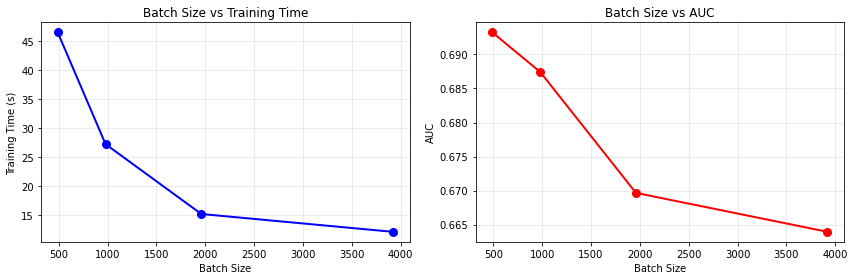

In [21]:
# Uncomment after running batch experiment:
plot_batch_results(batch_results)

## 2. Model Architecture Experiments

Test different model architectures to see how parameters affect performance.

In [22]:
# Model architecture configurations to test
model_configs = [
    {"name": "Small (32)", "layers": [32], "dropout": 0.3},
    {"name": "Small (64)", "layers": [64], "dropout": 0.3},
    {"name": "Small (128)", "layers": [128], "dropout": 0.3},
    {"name": "Medium (64-32)", "layers": [64, 32], "dropout": 0.5},
    {"name": "Large (128-64-32)", "layers": [128, 64, 32], "dropout": 0.5},
    {"name": "XLarge (256-128-64)", "layers": [256, 128, 64], "dropout": 0.5},
    {"name": "Deep (64-64-64-64)", "layers": [64, 64, 64, 64], "dropout": 0.4},
]


def create_model(input_size, config):
    """Create a model based on configuration."""
    model = Sequential()

    # First layer with input shape
    model.add(Dense(config["layers"][0], input_shape=(input_size,)))
    model.add(Activation("relu"))
    model.add(Dropout(config["dropout"]))

    # Hidden layers
    for units in config["layers"][1:]:
        model.add(Dense(units))
        model.add(Activation("relu"))
        model.add(Dropout(config["dropout"]))

    # Output layer
    model.add(Dense(1))
    model.add(Activation("sigmoid"))

    model.compile(
        loss="binary_crossentropy", optimizer=Adam(lr=0.001), metrics=["accuracy"]
    )
    return model


def count_parameters(config, input_size):
    """Estimate number of trainable parameters."""
    params = 0
    prev_size = input_size
    for units in config["layers"]:
        params += (prev_size + 1) * units  # weights + bias
        prev_size = units
    params += (prev_size + 1) * 1  # output layer
    return params


def run_architecture_experiment(
    train_df, test_df, configs, num_epochs=5, BigDLbatch=980
):
    """Test different model architectures."""
    results = []
    input_size = train_df.select("features").first()[0].size

    for config in configs:
        print(f"\n{'=' * 50}")
        print(f"Testing: {config['name']}")
        num_params = count_parameters(config, input_size)
        print(f"Estimated parameters: {num_params:,}")
        print(f"{'=' * 50}")

        model = create_model(input_size, config)

        estimator = (
            NNEstimator(model, BinaryCrossEntropy())
            .setOptimMethod(Adam())
            .setBatchSize(BigDLbatch)
            .setMaxEpoch(num_epochs)
            .setFeaturesCol("features")
            .setLabelCol("label")
        )

        start_time = time.time()
        trained_model = estimator.fit(train_df)
        training_time = time.time() - start_time

        # Evaluate
        predDF = trained_model.transform(test_df)
        y_pred = np.asarray(predDF.select("prediction").collect())[:, 0]
        y_true = np.asarray(test_df.select("label").collect())[:, 0]
        auc = roc_auc_score(y_true, y_pred)

        results.append(
            {
                "model": config["name"],
                "num_params": num_params,
                "training_time": training_time,
                "auc": auc,
            }
        )
        print(f"Training time: {training_time:.2f}s, AUC: {auc:.4f}")

    return pd.DataFrame(results)


In [23]:
# Uncomment to run experiment:
arch_results = run_architecture_experiment(
    train, test, model_configs, num_epochs=5, BigDLbatch=BigDLbatch
)
print("\n\nArchitecture Results:")
print(arch_results)


Testing: Small (32)
Estimated parameters: 961
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasActivation
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasActivation
creating: createZooKerasAdam
creating: createDefault
creating: createZooKerasBinaryCrossEntropy
creating: createZooKerasBinaryAccuracy
creating: createZooKerasBinaryCrossEntropy
creating: createSeqToTensor
creating: createSeqToTensor
creating: createFeatureLabelPreprocessing
creating: createNNEstimator
creating: createZooKerasAdam
creating: createDefault
creating: createToTuple
creating: createChainedPreprocessing
Training time: 31.41s, AUC: 0.6549

Testing: Small (64)
Estimated parameters: 1,921
creating: createZooKerasSequential
creating: createZooKerasDense
creating: createZooKerasActivation
creating: createZooKerasDropout
creating: createZooKerasDense
creating: createZooKerasActivation
creating: createZooKerasAdam
creating: createDefault
crea

In [24]:
# Visualize architecture results (answers Q2 and Q3)
def plot_architecture_results(results_df):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Training time vs parameters
    axes[0].scatter(
        results_df["num_params"],
        results_df["training_time"],
        s=100,
        c="blue",
        alpha=0.7,
    )
    for i, row in results_df.iterrows():
        axes[0].annotate(
            row["model"],
            (row["num_params"], row["training_time"]),
            fontsize=8,
            ha="center",
            va="bottom",
        )
    axes[0].set_xlabel("Number of Parameters")
    axes[0].set_ylabel("Training Time (s)")
    axes[0].set_title("Parameters vs Training Time")
    axes[0].grid(True, alpha=0.3)

    # AUC vs parameters
    axes[1].scatter(
        results_df["num_params"], results_df["auc"], s=100, c="red", alpha=0.7
    )
    for i, row in results_df.iterrows():
        axes[1].annotate(
            row["model"],
            (row["num_params"], row["auc"]),
            fontsize=8,
            ha="center",
            va="bottom",
        )
    axes[1].set_xlabel("Number of Parameters")
    axes[1].set_ylabel("AUC")
    axes[1].set_title("Parameters vs Performance (AUC)")
    axes[1].grid(True, alpha=0.3)

    # Bar chart comparison
    x = np.arange(len(results_df))
    width = 0.35
    ax2 = axes[2].twinx()
    bars1 = axes[2].bar(
        x - width / 2,
        results_df["training_time"],
        width,
        label="Time (s)",
        color="steelblue",
    )
    bars2 = ax2.bar(x + width / 2, results_df["auc"], width, label="AUC", color="coral")
    axes[2].set_xlabel("Model")
    axes[2].set_ylabel("Training Time (s)", color="steelblue")
    ax2.set_ylabel("AUC", color="coral")
    axes[2].set_xticks(x)
    axes[2].set_xticklabels(results_df["model"], rotation=45, ha="right")
    axes[2].set_title("Model Comparison")

    plt.tight_layout()
    plt.show()


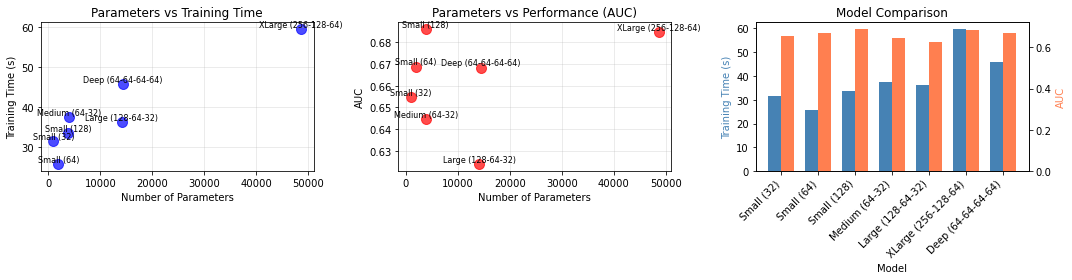

In [25]:
# Uncomment after running architecture experiment:
plot_architecture_results(arch_results)

## 3. Scaling Tests (Training Time vs Number of Workers)

**Note:** This requires restarting Spark with different worker configurations.  
Run the cell below, then restart the notebook kernel and re-run from the beginning with a different `num_workers` value.

In [26]:
# Scaling test framework
# MANUAL PROCESS: Record results for different num_workers values
# 1. Set num_workers in cell 3 (e.g., 1, 2, 3, 4, 5, 6, 7)
# 2. Run the notebook through training
# 3. Record the training time below

# Example results template (fill in after each run):
cols = ["num_workers", "training_time", "auc"]
scaling_results = pd.read_table("scaling_results.tsv", header=None, names=cols)

# Example of filled results (replace with your actual measurements):
# scaling_results = pd.DataFrame({
#     'num_workers': [1, 2, 3, 4, 5, 6, 7],
#     'training_time': [120, 65, 45, 35, 30, 27, 25],  # seconds
#     'auc': [0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78],
# })

print("Scaling Test Template:")
print(
    "After each run, update the scaling_results DataFrame above with your measurements."
)
print(scaling_results)

Scaling Test Template:
After each run, update the scaling_results DataFrame above with your measurements.
   num_workers  training_time    auc
0            1     265.475219  0.743
1            2     198.295666  0.733
2            3     109.279817  0.726
3            4      88.968803  0.724
4            5      96.844771  0.707
5            6      73.389260  0.708
6            7      61.322459  0.714


In [27]:
# Visualize scaling results
def plot_scaling_results(results_df):
    # Filter out None values
    valid_df = results_df.dropna()

    if len(valid_df) == 0:
        print(
            "No scaling results recorded yet. Run the notebook with different num_workers values."
        )
        return

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    # Training time vs workers
    axes[0].plot(
        valid_df["num_workers"],
        valid_df["training_time"],
        "bo-",
        linewidth=2,
        markersize=8,
    )
    axes[0].set_xlabel("Number of Workers")
    axes[0].set_ylabel("Training Time (s)")
    axes[0].set_title("Scaling: Workers vs Training Time")
    axes[0].grid(True, alpha=0.3)

    # Speedup calculation
    if valid_df["training_time"].iloc[0] is not None:
        baseline = valid_df["training_time"].iloc[0]
        speedup = baseline / valid_df["training_time"]
        ideal_speedup = valid_df["num_workers"] / valid_df["num_workers"].iloc[0]

        axes[1].plot(
            valid_df["num_workers"],
            speedup,
            "go-",
            linewidth=2,
            markersize=8,
            label="Actual Speedup",
        )
        axes[1].plot(
            valid_df["num_workers"],
            ideal_speedup,
            "r--",
            linewidth=2,
            label="Ideal (Linear) Speedup",
        )
        axes[1].set_xlabel("Number of Workers")
        axes[1].set_ylabel("Speedup")
        axes[1].set_title("Scaling Efficiency")
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

    # AUC vs workers
    axes[2].plot(
        valid_df["num_workers"],
        valid_df["auc"],
        "go-",
        linewidth=2,
        markersize=8,
    )
    axes[2].set_xlabel("Number of Workers")
    axes[2].set_ylabel("AUC")
    axes[2].set_title("Scaling: Workers vs AUC")
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

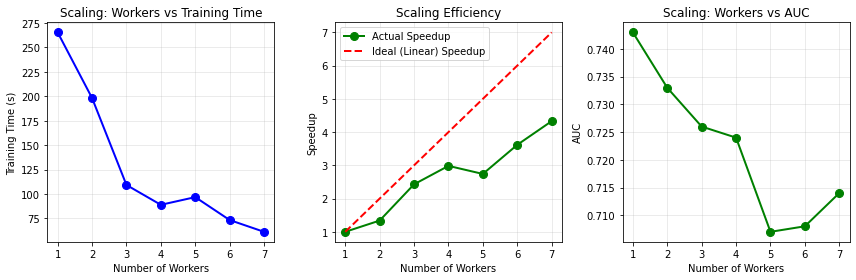

In [28]:
# Uncomment after filling in scaling_results:
plot_scaling_results(scaling_results)

## 4. Comparison with MCP and Keras Models

Record results from your previous notebook runs (ML_MCP.ipynb and Keras.ipynb) for comparison.

In [29]:
# Model comparison across different frameworks
# Fill in results from your previous notebooks

comparison_results = pd.DataFrame(
    {
        "Model": ["MCP (MLlib)", "Keras (single node)", "BigDL (distributed)"],
        "Framework": ["Spark MLlib", "TensorFlow/Keras", "BigDL on Spark"],
        "Training_Time_s": [None, None, None],  # Fill from your runs
        "AUC": [None, None, None],  # Fill from your runs
        "Dataset": ["Higgs100k", "Higgs100k", "Higgs100k"],  # Adjust as needed
        "Notes": [
            "Multi-layer Perceptron classifier",
            "Sequential NN, single GPU/CPU",
            "Distributed training on Spark",
        ],
    }
)

# Example filled comparison (replace with actual values):
# comparison_results = pd.DataFrame({
#     'Model': ['MCP (MLlib)', 'Keras (single node)', 'BigDL (distributed)'],
#     'Framework': ['Spark MLlib', 'TensorFlow/Keras', 'BigDL on Spark'],
#     'Training_Time_s': [45, 30, 25],
#     'AUC': [0.76, 0.79, 0.78],
#     'Dataset': ['Higgs100k', 'Higgs100k', 'Higgs100k'],
#     'Notes': [
#         'Multi-layer Perceptron classifier',
#         'Sequential NN, single GPU/CPU',
#         'Distributed training on 7 workers'
#     ]
# })

print("Model Comparison Template:")
print("Fill in results from ML_MCP.ipynb and Keras.ipynb notebooks")
print(comparison_results.to_string(index=False))

Model Comparison Template:
Fill in results from ML_MCP.ipynb and Keras.ipynb notebooks
              Model        Framework Training_Time_s  AUC   Dataset                             Notes
        MCP (MLlib)      Spark MLlib            None None Higgs100k Multi-layer Perceptron classifier
Keras (single node) TensorFlow/Keras            None None Higgs100k     Sequential NN, single GPU/CPU
BigDL (distributed)   BigDL on Spark            None None Higgs100k     Distributed training on Spark


In [30]:
# Visualize model comparison
def plot_model_comparison(results_df):
    # Filter out None values
    valid_df = results_df.dropna(subset=["Training_Time_s", "AUC"])

    if len(valid_df) == 0:
        print("No comparison results recorded yet.")
        return

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    colors = ["#2ecc71", "#3498db", "#e74c3c"]

    # Training time comparison
    bars1 = axes[0].barh(
        valid_df["Model"], valid_df["Training_Time_s"], color=colors[: len(valid_df)]
    )
    axes[0].set_xlabel("Training Time (seconds)")
    axes[0].set_title("Training Time Comparison")
    axes[0].grid(True, alpha=0.3, axis="x")
    for i, (bar, time) in enumerate(zip(bars1, valid_df["Training_Time_s"])):
        axes[0].text(
            bar.get_width() + 1,
            bar.get_y() + bar.get_height() / 2,
            f"{time:.1f}s",
            va="center",
            fontsize=10,
        )

    # AUC comparison
    bars2 = axes[1].barh(
        valid_df["Model"], valid_df["AUC"], color=colors[: len(valid_df)]
    )
    axes[1].set_xlabel("AUC Score")
    axes[1].set_title("Model Performance (AUC) Comparison")
    axes[1].set_xlim(0.5, 1.0)
    axes[1].grid(True, alpha=0.3, axis="x")
    for i, (bar, auc) in enumerate(zip(bars2, valid_df["AUC"])):
        axes[1].text(
            bar.get_width() + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{auc:.4f}",
            va="center",
            fontsize=10,
        )

    plt.tight_layout()
    plt.show()

    # Summary table
    print("\n" + "=" * 60)
    print("SUMMARY: Model Comparison")
    print("=" * 60)
    print(
        valid_df[["Model", "Framework", "Training_Time_s", "AUC"]].to_string(
            index=False
        )
    )


# Uncomment after filling in comparison_results:
# plot_model_comparison(comparison_results)